In [15]:
import re
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
import sklearn.model_selection as ms
import sklearn.preprocessing as pp
import sklearn.feature_selection as fs
from sklearn.cross_validation import StratifiedKFold
from sklearn import metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
from features1 import add_title,fill_age,fill_fare,fill_embarked,fill_cabin,fill_ticket,add_family


In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
total=pd.concat([train,test])
PassengerId=total['PassengerId']

In [6]:
# Add title, drop name, add family
total=add_title(total)
total.drop('Name',axis=1,inplace=True)# Fill
total=add_family(total)

In [7]:
# Fill age, fare, embarked
total=fill_age(total)
total=fill_fare(total)
total=fill_embarked(total)
total=fill_cabin(total)
total=fill_ticket(total)

/home/wing/.virtualenvs/cv/local/lib/python2.7/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/wing/.virtualenvs/cv/local/lib/python2.7/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [8]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 16 columns):
Age            1309 non-null float64
Cabin          1309 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Title          1309 non-null object
FamilySize     1309 non-null int64
Singleton      1309 non-null int64
SmallFamily    1309 non-null int64
LargeFamily    1309 non-null int64
dtypes: float64(3), int64(8), object(5)
memory usage: 173.9+ KB


In [9]:
# Turn binary (titles) 
total = pd.concat([total,pd.get_dummies(total['Title'],prefix='Title')],axis=1)
total = pd.concat([total,pd.get_dummies(total['Embarked'],prefix='Embarked')],axis=1)
total = pd.concat([total,pd.get_dummies(total['Cabin'], prefix='Cabin')], axis=1)
total = pd.concat([total,pd.get_dummies(total['Pclass'], prefix="Pclass")],axis=1) 
total['Sex'] = total['Sex'].map({'male':1,'female':0})
total = pd.concat([total, pd.get_dummies(total['Ticket'], prefix='Ticket')], axis=1)


In [10]:
# Drop
total.drop('Title',axis=1,inplace=True)
total.drop('Embarked',axis=1,inplace=True)
total.drop('Cabin', axis=1, inplace=True)
total.drop('Pclass',axis=1,inplace=True)
total.drop('Ticket', inplace=True, axis=1)
total.drop('PassengerId', inplace=True, axis=1)
total.drop('Survived', axis=1, inplace=True)

In [11]:
data_y=train['Survived']
data_x=total.iloc[range(len(data_y))]
test_x=total.iloc[len(data_y):]



[0]	train-auc:0.884857	test-auc:0.86643
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[1]	train-auc:0.896297	test-auc:0.876603
[2]	train-auc:0.89986	test-auc:0.877299
[3]	train-auc:0.903302	test-auc:0.878493
[4]	train-auc:0.905357	test-auc:0.881776
[5]	train-auc:0.9093	test-auc:0.88245
[6]	train-auc:0.911808	test-auc:0.884213
[7]	train-auc:0.912609	test-auc:0.884223
[8]	train-auc:0.915291	test-auc:0.883245
[9]	train-auc:0.920545	test-auc:0.884333
[10]	train-auc:0.921575	test-auc:0.884188
[11]	train-auc:0.92311	test-auc:0.880342
[12]	train-auc:0.925052	test-auc:0.879178
[13]	train-auc:0.927337	test-auc:0.881221
[14]	train-auc:0.928314	test-auc:0.880958
[15]	train-auc:0.929542	test-auc:0.880189
[16]	train-auc:0.93162	test-auc:0.881898
[17]	train-auc:0.932208	test-auc:0.881768
[18]	train-auc:0.933249	test-auc:0.881326
[19]	train-auc:0.934957	test-auc:0.882469
[20]	train-auc:0.935333	test-auc:0.8

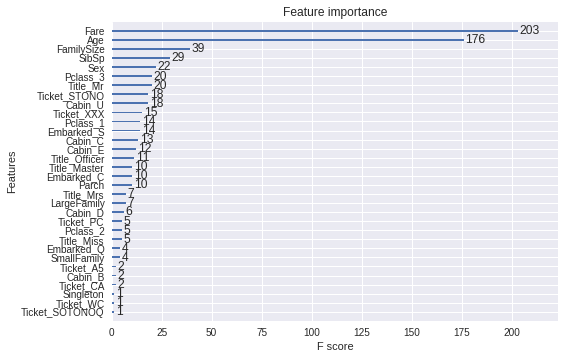

In [12]:
#param_grid = {'n_estimators'=
#              'max_depth':range(3,6,1), 
#              'min_child_weight':range(1,6,1),
#              'gamma':[i/10.0 for i in range(2,8)],
#              'subsample':[i/100.0 for i in range(60,100,5)],
#              'colsample_bytree':[i/100.0 for i in range(60,100,5)]}

model = xgb.XGBClassifier(learning_rate =0.1, 
                      n_estimators=1000, 
                      max_depth=5,
                      min_child_weight=1, 
                      gamma=0.1, 
                      subsample=0.8, 
                      colsample_bytree=0.8,
                      reg_alpha=0,
                      objective= 'binary:logistic', 
                      n_jobs=4, 
                      scale_pos_weight=1,
                      random_state = 1)

xgbTrain = xgb.DMatrix(data_x, label=data_y)
xgbParams = model.get_xgb_params()
cv_result=xgb.cv(xgbParams,
                 xgbTrain,
                 stratified=True,
                 num_boost_round=model.get_params()['n_estimators'],
                 nfold= 5,
                 metrics='auc',
                 early_stopping_rounds=50,
                 callbacks=[xgb.callback.print_evaluation(show_stdv=False), xgb.callback.early_stop(50)],
                 seed=15
                 )

model.set_params(n_estimators=cv_result.shape[0])
model.fit(data_x,data_y, eval_metric='auc')

predictions = model.predict(data_x)
pred_prob = model.predict_proba(data_x)[:,1]


print "\nModel Report"
print "Accuracy : %.4g" % metrics.accuracy_score(data_y, predictions)
print "AUC Score (Train): %f" % metrics.roc_auc_score(data_y, pred_prob)
#grid = ms.GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', n_jobs=-1, verbose=1)
#grid.fit(train_x,train_y)

xgb.plot_importance(model)
plt.show()


In [14]:
model1 = fs.SelectFromModel(model, prefit=True)
data_x_reduced = model1.transform(data_x)
data_x_reduced.shape
test_x_reduced = model1.transform(test_x)
test_x_reduced.shape

(418, 15)

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

cv_folds = StratifiedKFold(data_y, n_folds=5)
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=42, max_depth=5,
 min_child_weight=1, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', n_jobs=4, reg_alpha=0, scale_pos_weight=1, random_state=1), 
 param_grid = param_test1, scoring='accuracy',n_jobs=-1,iid=False, cv=cv_folds)
gsearch1.fit(data_x_reduced,data_y)
print "cv_results............................."
print gsearch1.cv_results_
print "best_params............................."
print gsearch1.best_params_
print "best_score_............................."
print gsearch1.best_score_

In [38]:
kfold = ms.StratifiedKFold(n_splits=5, random_state=1)
cv_results = ms.cross_val_score(model, data_x_reduced, data_y, cv=kfold)

print cv_results
print str(cv_results.mean()*100)+"%("+str(cv_results.std()*100)+"%)"


[ 0.83240223  0.80446927  0.88202247  0.81460674  0.84180791]
83.5061726294%(2.68782442394%)


In [3]:
#test_predictions = model.predict(total.iloc[len(train_all):])
#submission = pd.DataFrame({ 'PassengerId': test['PassengerId'],
#                            'Survived': test_predictions })
#submission.to_csv("submission.csv", index=False)